Import packages and the dataset

In [1]:
from google.colab import files

data_to_load = files.upload()

Saving heart.csv to heart.csv


In [96]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['heart.csv']))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [5]:
df.shape

(918, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Number of sicks is a bit higher

In [7]:
df.HeartDisease.value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

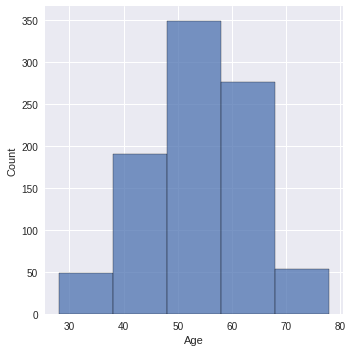

In [8]:
# Distribution of ages: looks normal
sns.displot(df.Age, binwidth=10)

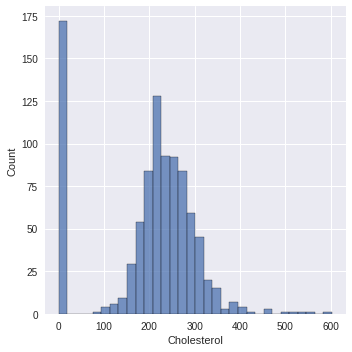

In [84]:
# Cholesterol levels
sns.displot(df.Cholesterol)

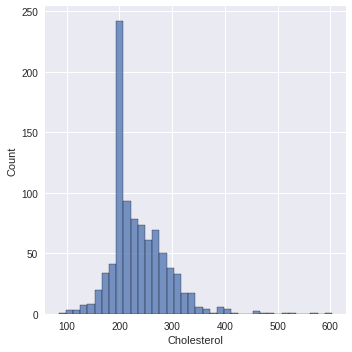

In [97]:
# we need to change the 'Cholesterol' levels of about 172 people, 0 amount it just not possible, the average level for those ages is around 200 mg
df.loc[df.Cholesterol == 0, "Cholesterol"] = 200
# Cholesterol levels
sns.displot(df.Cholesterol)

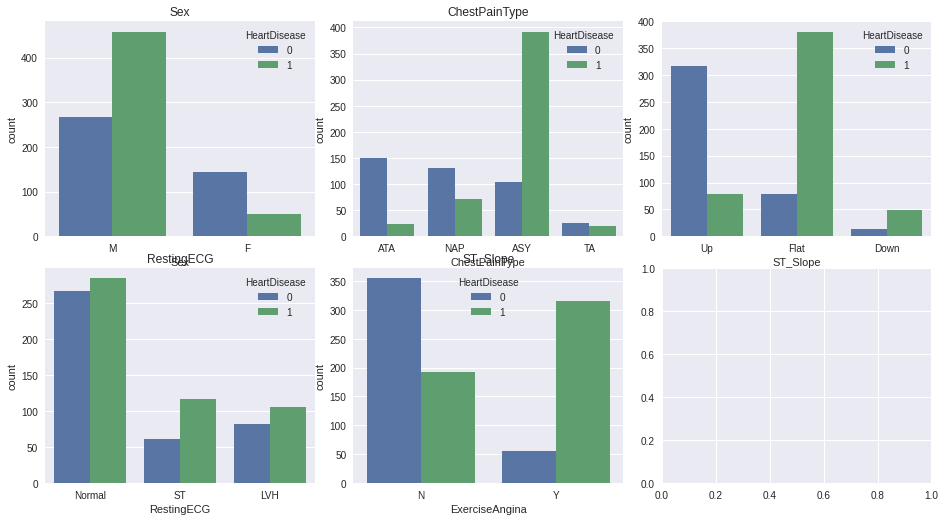

In [69]:
# HeartDisease rate vs categorical data
cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

n_rows = 2
n_cols = 2

#define subplots
fig, axs = plt.subplots(2, 3, figsize=(13,7))
fig.tight_layout()

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        i = r*n_cols+ c    
        ax = axs[r][c]
        sns.countplot(x = df[cols[i]], hue=df['HeartDisease'], ax=ax)
        ax.set_title(cols[i])
        ax.legend(title='HeartDisease')

sns.countplot(x = df[cols[4]], hue=df['HeartDisease'], ax=axs[0][2])
ax.set_title(cols[4])
ax.legend(title='HeartDisease')

Xgboost only knows to work with numeric or boolean data, so we need to change the columns of categorical data which are not numeric or boolean such as:
* Sex
* ChestPainType
* RestingECG
* ExerciseAngina
* ST_Slope

In [10]:
# process the dataset to work with xgboost
def preprocess(df):

   df_processed = df
   # One hot encoding to change all non - numeric/boolean categorical data
   categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
   for cname in categorical_columns:
       dummies = pd.get_dummies(df_processed[cname], prefix=cname)
       df_processed = pd.concat([df_processed, dummies], axis=1)
       df_processed.drop([cname], axis=1, inplace=True)
    
   return df_processed

In [98]:
df_processed = preprocess(df)

In [99]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    int64  
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   HeartDisease       918 non-null    int64  
 7   Sex_F              918 non-null    uint8  
 8   Sex_M              918 non-null    uint8  
 9   ChestPainType_ASY  918 non-null    uint8  
 10  ChestPainType_ATA  918 non-null    uint8  
 11  ChestPainType_NAP  918 non-null    uint8  
 12  ChestPainType_TA   918 non-null    uint8  
 13  RestingECG_LVH     918 non-null    uint8  
 14  RestingECG_Normal  918 non-null    uint8  
 15  RestingECG_ST      918 non-null    uint8  
 16  ExerciseAngina_N   918 non

In [100]:
y = df_processed.pop('HeartDisease')
 
X = df_processed

In [101]:
from sklearn.model_selection import train_test_split
seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y,
   train_size=.7,
   random_state=seed,
   stratify=y)

In [102]:
import time
import xgboost as xgb
# create a default XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, early_stopping_rounds=10)
# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
# fit the model
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

CPU times: user 221 ms, sys: 1.45 ms, total: 223 ms
Wall time: 223 ms


XGBClassifier(early_stopping_rounds=10)

In [103]:
y_pred = model.predict(X_test)

In [104]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cf_matrix): 
    print('Confusion Matrix')
    
    ax= plt.subplot()
    sns.heatmap(cf_matrix, annot=True, ax = ax, fmt='d', cmap='Blues', cbar=False)

    # labels, title and ticks
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('Actual labels')
    ax.xaxis.set_ticklabels(['HeartDisease', 'Normal']) 
    ax.yaxis.set_ticklabels(['HeartDisease', 'Normal'])

Confusion Matrix


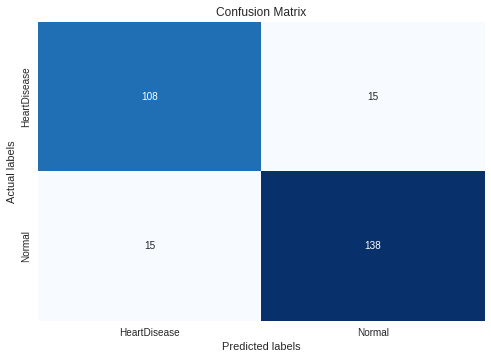

In [105]:
cf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf_matrix)

In [106]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       123
           1       0.90      0.90      0.90       153

    accuracy                           0.89       276
   macro avg       0.89      0.89      0.89       276
weighted avg       0.89      0.89      0.89       276



In [107]:
# Feature Importance
def get_feature_importance(model):
    features_list = list(model.get_booster().get_fscore().items())
    features_df = pd.DataFrame(features_list, columns=['feature','importance']).sort_values('importance', ascending=False)
    return features_df
    
get_feature_importance(model)

,feature,importance
2,MaxHR,126
11,Cholesterol,92
4,Oldpeak,85
8,RestingBP,65
1,ChestPainType_ASY,54
6,Age,52
3,Sex_F,36
5,FastingBS,36
0,ST_Slope_Up,21
10,RestingECG_LVH,19


We can use optimization algorithms from scikit hyperparameter optimizer functions such as Grid Search and Random Search.

Using Grid Search we can find the best value for max_depth, learning_rate, n_estimators, early_stopping_rounds, colsample_bytree.

We choose some common values for those and observe the results.

In [108]:
from sklearn.model_selection import GridSearchCV
# Optimizing parameters and improve our model:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 150, 200],
           'early_stopping_rounds': [10,15],
           'colsample_bytree': [0.3, 0.7]}
xgbc = xgb.XGBClassifier(seed = seed)
clf = GridSearchCV(estimator=xgbc, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=XGBClassifier(seed=42),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'early_stopping_rounds': [10, 15],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [109]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.3, 'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Lowest RMSE:  0.3723094695079234


Actually, we got the same hyperparameters for our model, one way to explain that is our dataset is relatively small and n_estimators=100 seems good for this case, also max_depth=3 can be explained by that.

model_output = "margin" has been renamed to model_output = "raw"


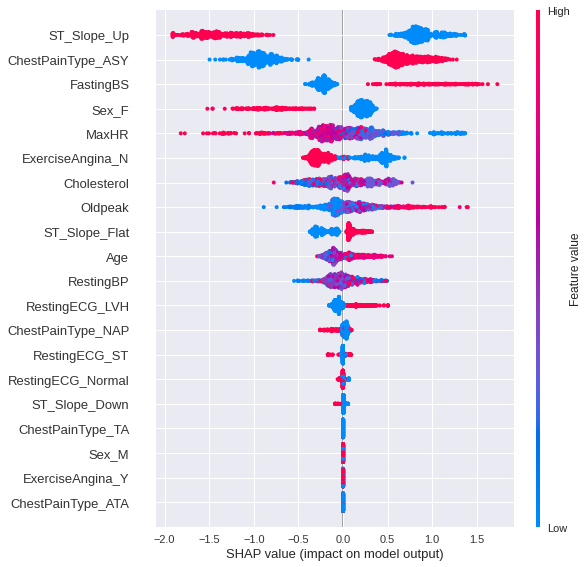

In [78]:
#Use SHAP to get some insights of our results:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model, model_output='margin')
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

**Insights:**
* The model predicts small rates to get an heart disease for people with increasing ST segment.
* Surprisingly, Cholesterol does not have high correlation with heart diseases
* Age does not have big impact on the predictions, it can be explained by the range from our dataset, most people are at the same ages (50-70)




In [34]:
# References:
# https://reshetech.co.il/machine-learning-tutorials/machine-learning-with-xgboost-to-see-the-wood-for-the-trees
# https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663